# 0.0 Introduction
This notebook will describe an algorithm which will take in reduced spectra and perform PCA

# 0.1 First pass

The first pass will have no care for error. The formatting of the data is faily poor this is just to get something acceptable working. There is also no science behind the sample selection. What type of stars do we wish to look at, what brightness, intersetllar dust extinction. This is just taking a certain random sample of HR10 and seeing what we can learn. Consider
https://arxiv.org/pdf/1001.4340.pdf

# 0.2 Imports

In [1]:
from astropy.io import fits
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")
from Data_handling.spectra_object import Spectrum, learning_data
from Data_handling.pca_functions import Pca_Fitting

from Data_handling.vae import Encoder,Decoder, VAE , loss_function

os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/Documents/GES/Analysis'

# 1.0 Data input for HR10 Sample

A sample of HR10 Giraffe spectra have been selected. We will use the data handling function to create a list of these
spectra with their object names. We will get a list of spectrum classes.

We will save the sample but this code will need to be run again if done with different sample.

In [2]:
'''
os.chdir("../Data")  #change to data set folder and get the file names
mypath=os.getcwd()
spectra = [f for f in listdir(mypath) if (isfile(join(mypath, f))and('.fits'in f))]
spectrum_list=[]
for i in range(0,len(spectra)):
    print(str(i) + ' out of ' + str(len(spectra)))
    spectrum_list.append(Spectrum(spectra[i],parameters=True)) #at the moment there are all hr10
'''

'\nos.chdir("../Data")  #change to data set folder and get the file names\nmypath=os.getcwd()\nspectra = [f for f in listdir(mypath) if (isfile(join(mypath, f))and(\'.fits\'in f))]\nspectrum_list=[]\nfor i in range(0,len(spectra)):\n    print(str(i) + \' out of \' + str(len(spectra)))\n    spectrum_list.append(Spectrum(spectra[i],parameters=True)) #at the moment there are all hr10\n'

In [3]:
# We now save these to a file

os.chdir('../Data')
#with open('class','wb') as f:
#    pickle.dump(spectrum_list,f)


In [4]:
with open('class', 'rb') as f:
    spectrum_list = pickle.load(f)
os.chdir('../Analysis')


# 1.1 Parameters for these samples

Some of the parameters have been included in the above

# 1.2 Example of a spectra

Spectrum name and column names

In [5]:
spectrum=spectrum_list[0]
print(spectrum.get_object)
spectrum.get_columns()

<bound method Spectrum.get_object of <Data_handling.spectra_object.Spectrum object at 0x1042b8a90>>


Index(['wavelength', 'flux', 'flux_err'], dtype='object')

Example of a spectrum

Plot of spectrum flux vs wavelength  
Units of wavelength are nm  
Units of flux are adu

This hasn't been included in class yet but will be.

In [6]:
flux_err_mean=np.mean(spectrum.data['flux_err'])
flux_err_std=np.std(spectrum.data['flux_err'])
five_sigma=[flux_err_mean-5*flux_err_std,flux_err_mean+5*flux_err_std]

<AxesSubplot:title={'center':'Plot of spectrum'}, xlabel='nm', ylabel='adu'>

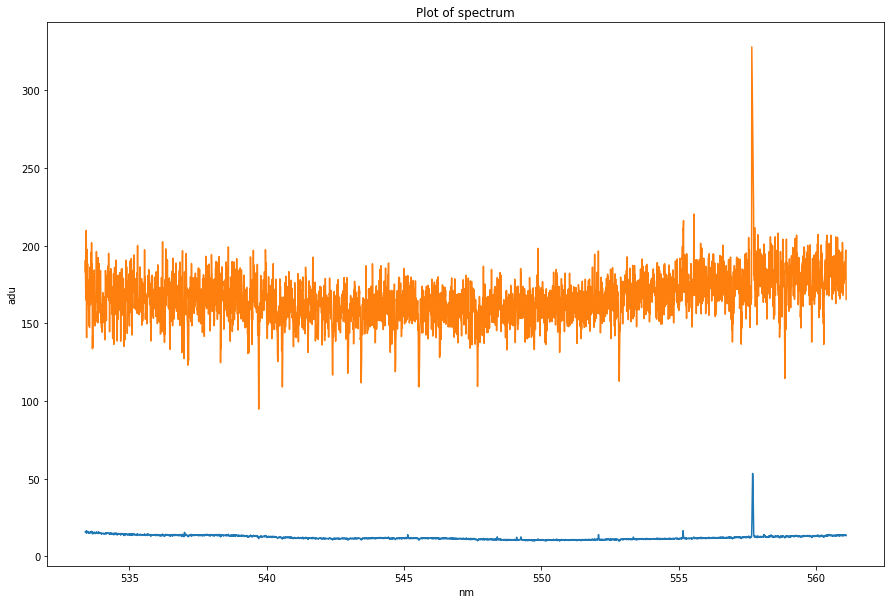

In [7]:

plt.figure(figsize=(15,10))
plt.title("Plot of spectrum")
plt.xlabel('nm')
plt.ylabel('adu')
#sn.lineplot(x=spectrum.data['wavelength'],y=spectrum.data['flux'])
sn.lineplot(x=spectrum.data['wavelength'],y=spectrum.data['flux_err'])
sn.lineplot(x=spectrum.data['wavelength'],y=spectrum.data[(spectrum.data['flux_err']>=five_sigma[0])&(spectrum.data['flux_err']<=five_sigma[1])]['flux'])


NB: After this the xaxis isn't scaled labeled for the wavelength values. Needs to be changed.

# 2.0 Principal C A

We first will normalise the data and the goal will be to do PCA on normalised.

Take the same example of a spectrum and perform PCA on it.

In [8]:
learning_spectra=[]
for i in range(0,len(spectrum_list)):
    learning_spectra.append(spectrum_list[i].data['flux'])

In [9]:
learning_spectra=np.array(learning_spectra)
np.shape(learning_spectra)

(1090, 5541)

Each row is a different spectra, of 5541 wavelength observations.

# 2.1 Algorithm setup

Define the PCA

In [10]:
pca=Pca_Fitting(learning_spectra,n_components=30)

The shape of our input spectra data is:

In [11]:
np.shape(learning_spectra)

(1090, 5541)

Fit to our data

spec_fitted is the PCA coefficients, where each row corresponds to a spectrum and the row vector describes the PCA coefficients associated to that spectrum. 

In [12]:
np.shape(pca.spec_fitted)


(1090, 30)

We should have low variance

In [13]:
pca.pca.explained_variance_ratio_

array([0.07114472, 0.06002875, 0.04437719, 0.03607096, 0.03307709,
       0.02991293, 0.0256096 , 0.02038178, 0.01790211, 0.01695893,
       0.01469364, 0.01444121, 0.01284861, 0.01260791, 0.01145168,
       0.00986998, 0.00820245, 0.00770745, 0.00761059, 0.00719804,
       0.00650761, 0.00633169, 0.00610862, 0.00598635, 0.00547125,
       0.00523914, 0.00515134, 0.00482498, 0.00478354, 0.00462846],
      dtype=float32)

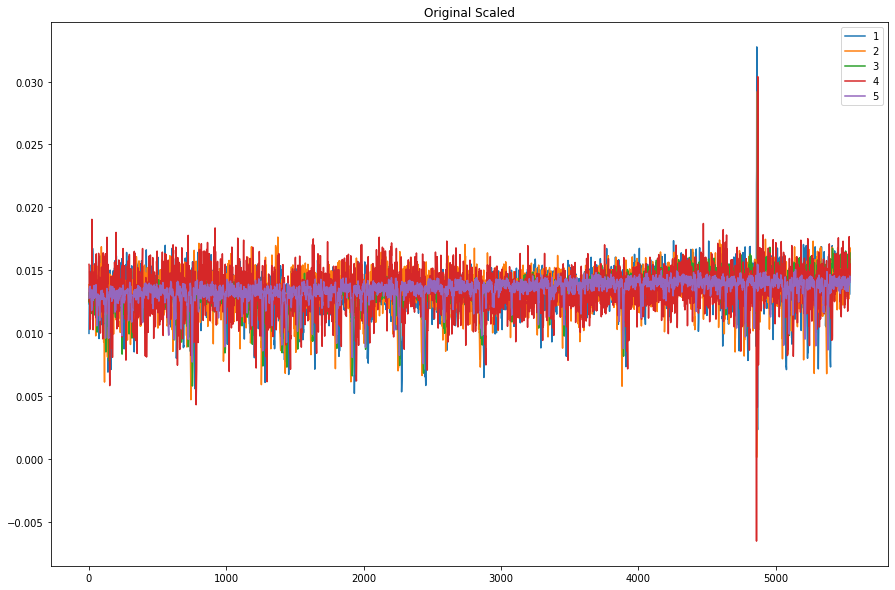

In [14]:
#Compare normalisation
plt.figure(figsize=(15,10))
pca.plot_normalised(1)
pca.plot_normalised(2)
pca.plot_normalised(3)
pca.plot_normalised(4)
pca.plot_normalised(5)

Comparing the reconstructed spectrum with the original.

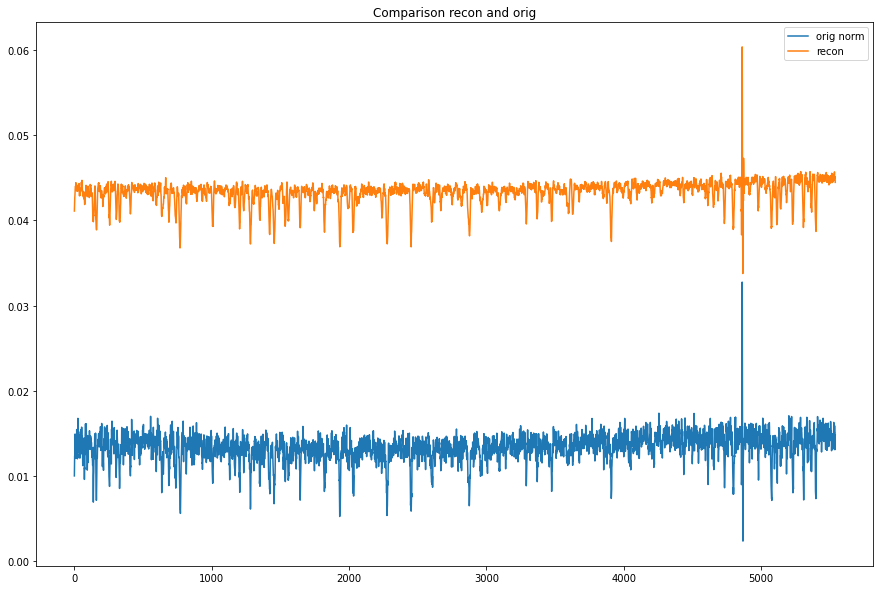

In [15]:
#example for first spectrum, the reconstructed spectrum is shifted up.
plt.figure(figsize=(15,10))
pca.plot_orig_and_recon_w_offset(1)

So this seems to be working okay. 

# 2.2 Analysis of PCA Fit

Start with plotting MSE per components and looking at reconstruction for different fits.

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


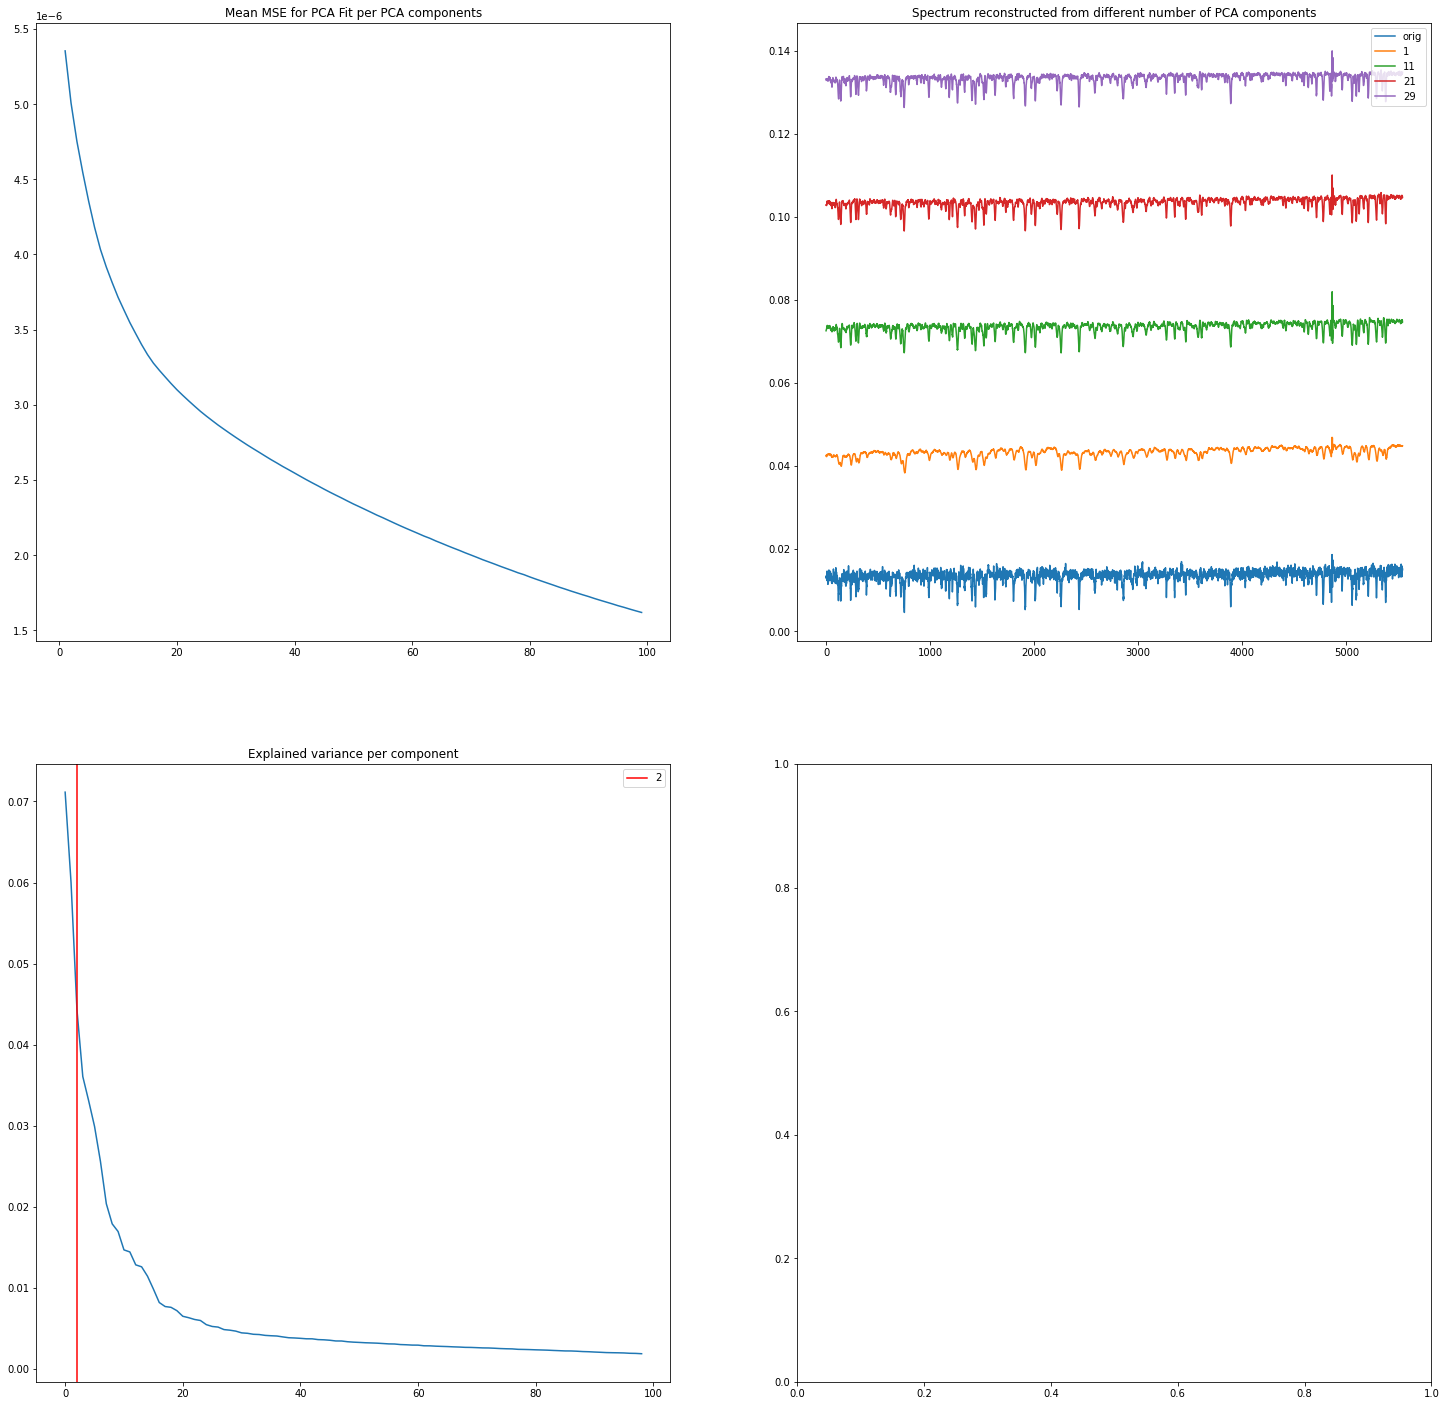

In [16]:
pca.mse_comparison_plot(components=100)


We can see there is a significant increase in goodness of fit after 3 components are used in PCA.

# Analysis of individual parts

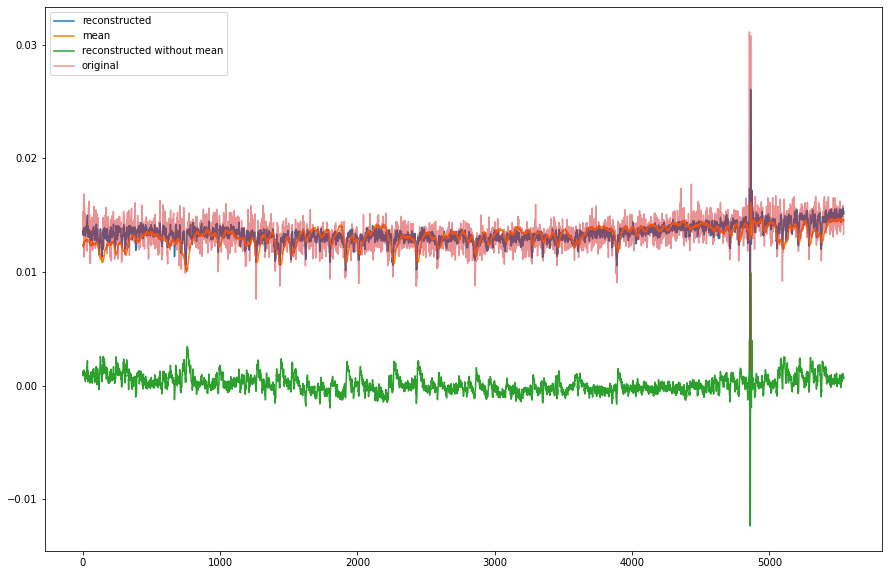

In [17]:
plt.figure(figsize=(15,10))
plt.plot(pca.reconstructed_spectrum[0],label='reconstructed')
plt.plot(pca.pca.mean_,label='mean')
plt.plot(pca.reconstructed_spectrum[0]-pca.pca.mean_,label='reconstructed without mean')
plt.plot(pca.learning_spectra[0],label='original',alpha=0.5)
plt.legend()

# 2.3 Analysis of Components
In what follows the practice will be very poor. We will utilise that the indices will be in the same order in spectrum_list[i] as in the learning_spectrum list. In future we need a better way of keeping track. The code above will need to be reviewed and changed.

## 2.3.1 Analysis of PCA Components

Again no consideration of error here.

In [18]:
os.chdir("../Parameter_files")
par=fits.open("GES_iDR6_WG15_Recommended_with_sflags__mode_normal_091221.fits")
os.chdir("../Analysis")
spectrum_list[0].parameters.columns

Index(['Name', 'GAIA_eDR3_ID', 'GAIA_dist', 'GES_TYPE', 'RA', 'DEC', 'TEFF',
       'TEFF_err', 'LOGG', 'LOGG_err', 'FEH', 'FEH_err', 'VR', 'VR_err'],
      dtype='object')

In [19]:

analysis=learning_data(spectrum_list,spectrum_list[0].parameters.columns)


Relationship between the first and second PCA coefficients for each spectra.


$$ \vec{x}_i=\vec{\mu}+(AB)_i$$
where the index $i$ corresponds to a row in the matrix learning_spectra. Moreover, $A$ is the 1090 by 100 matrix spec_fitted, $B$ is the 100 by 5541 matrix pca.pca.components_.    

The above equation seems to be able to succesfuly reconstruct the spectra. Below I plot the first column of A against the second column of A.

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

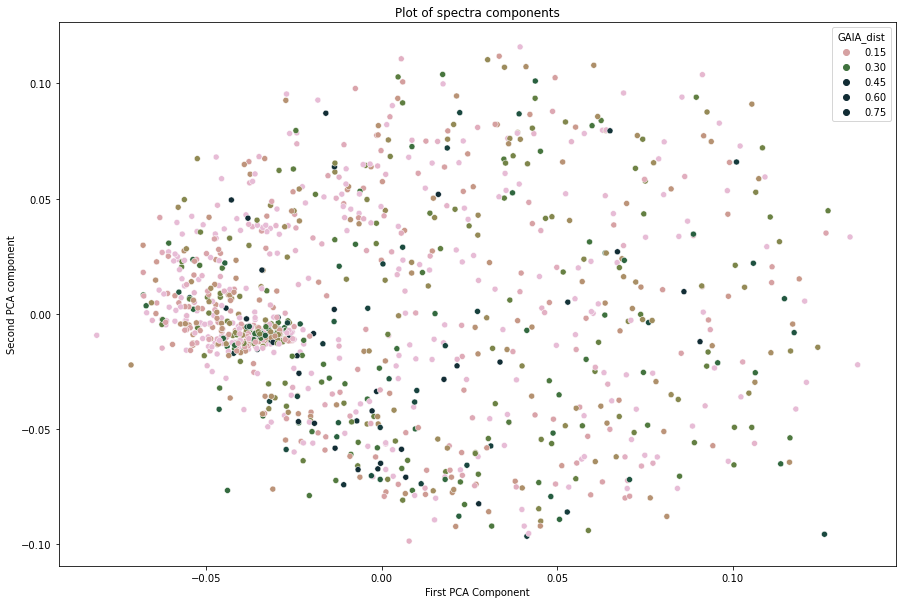

In [20]:
pca_coeff=pd.DataFrame(data=pca.spec_fitted)
pca_analysis=pd.concat([analysis,pca_coeff],axis=1)
pca_analysis=pca_analysis[pca_analysis['GAIA_dist']!='nan']

pca_analysis['GAIA_dist']=pca_analysis['GAIA_dist'].astype(float)

plt.figure(figsize=(15,10))
sn.scatterplot(data=pca_analysis,x=0,y=1, hue='GAIA_dist', palette="ch:r=-1,l=.8",hue_norm=(0.1,0.4))

plt.title('Plot of spectra components')
plt.ylabel('Second PCA component')
plt.xlabel('First PCA Component')

sn.heatmap

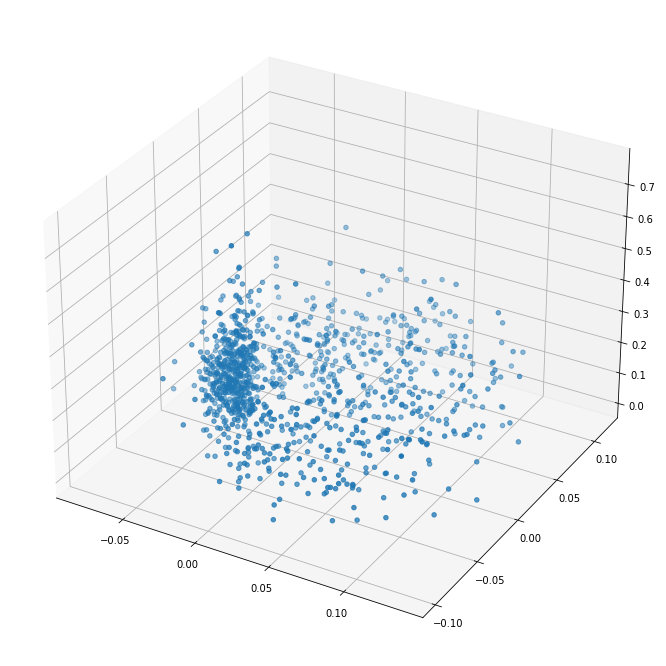

In [21]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

sequence_containing_x_vals = pca_analysis[0]
sequence_containing_y_vals = pca_analysis[1]
sequence_containing_z_vals = pca_analysis['GAIA_dist']


ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
plt.show()

# 3.0 Variational Autoencoders.

In [33]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam
from torch.utils.data import DataLoader

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100
lr = 1e-3
epochs = 30

In [34]:
vae_spec=DataLoader(pca.learning_spectra,batch_size=batch_size) 

In [24]:
zdim=2
encoder = Encoder(input_dim=vae_spec.shape[1], hidden_dim=2, z_dim=zdim)
decoder = Decoder(output_dim=vae_spec.shape[1], hidden_dim = 2, z_dim=zdim)

model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [25]:
optimizer=Adam(model.parameters(),lr=lr)


In [26]:
vae_spec_tensor=torch.tensor(vae_spec)
for y,  x in enumerate(vae_spec_tensor):
    print(x) 
    print(y)
x

tensor([0.0147, 0.0153, 0.0146,  ..., 0.0150, 0.0149, 0.0133])
0
tensor([0.0100, 0.0117, 0.0124,  ..., 0.0137, 0.0147, 0.0148])
1
tensor([0.0139, 0.0138, 0.0135,  ..., 0.0158, 0.0168, 0.0148])
2
tensor([0.0127, 0.0125, 0.0129,  ..., 0.0164, 0.0160, 0.0155])
3
tensor([0.0155, 0.0154, 0.0134,  ..., 0.0144, 0.0151, 0.0155])
4
tensor([0.0128, 0.0128, 0.0130,  ..., 0.0142, 0.0145, 0.0141])
5
tensor([0.0123, 0.0120, 0.0131,  ..., 0.0138, 0.0142, 0.0146])
6
tensor([0.0066, 0.0086, 0.0093,  ..., 0.0156, 0.0125, 0.0136])
7
tensor([0.0119, 0.0121, 0.0121,  ..., 0.0140, 0.0151, 0.0156])
8
tensor([0.0130, 0.0130, 0.0130,  ..., 0.0146, 0.0148, 0.0140])
9
tensor([0.0150, 0.0142, 0.0135,  ..., 0.0146, 0.0124, 0.0142])
10
tensor([0.0016, 0.0081, 0.0094,  ..., 0.0121, 0.0124, 0.0129])
11
tensor([0.0194, 0.0159, 0.0129,  ..., 0.0149, 0.0162, 0.0163])
12
tensor([0.0126, 0.0122, 0.0135,  ..., 0.0148, 0.0148, 0.0147])
13
tensor([0.0157, 0.0184, 0.0094,  ..., 0.0100, 0.0084, 0.0114])
14
tensor([0.0106, 0.01

tensor([0.0118, 0.0121, 0.0128,  ..., 0.0149, 0.0145, 0.0152])

In [32]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(vae_spec_tensor):
        x = x.view(1, vae_spec.shape[1])
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


NotImplementedError: 